In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import ttest_ind

In [2]:
task1_df = pd.read_csv("data/task1_preprocessed.csv")
task2_df = pd.read_csv("data/task2_preprocessed.csv")
os.makedirs("figures", exist_ok=True)

In [3]:
task1_ai_group = task1_df[task1_df['ai'] == True]
task1_manual_group = task1_df[task1_df['ai'] == False]
task2_treatment = task2_df[task2_df['treatment'] == 'ai']
task2_control = task2_df[task2_df['treatment'] == 'human']

In [4]:
# Define Likert scale columns
likert_columns = ['exit-space-1', 'exit-space-2', 'exit-space-3', 'exit-space-4', 'exit-space-5',
                  'exit-space-6', 'exit-space-7', 'exit-space-8', 'exit-space-9', 'exit-space-10']
inverted_items = ['exit-space-4', 'exit-space-10']

# Define human-readable labels for the Likert items
column_labels = {
    'exit-space-1': "Focused on Task",
    'exit-space-2': "Felt Productive",
    'exit-space-3': "Felt Fulfilled",
    'exit-space-4': "Frustration (INVERTED)",
    'exit-space-5': "Fast Progress",
    'exit-space-6': "High Code Quality",
    'exit-space-7': "Maintained Flow",
    'exit-space-8': "Enjoyed Task",
    'exit-space-9': "Completed Repetitive Tasks Fast",
    'exit-space-10': "Time Spent Searching (INVERTED)"
}

In [5]:
# Define color scheme
colors = {
    'ai_dark_gray': '#4F4F4F',
    'manual_work': 'yellow',
    'treatment_blue': '#1f77b4',  # Blue for treatment
    'control_orange': '#ff7f0e'  # Orange for control
}

# Perceived productivity

In [6]:
# Task 1 descriptive statistics for PP by AI group
task1_pp_stats = (
    task1_df.groupby('ai')['pp_mean']
    .describe()[['count', 'mean', 'std', 'min', '50%', 'max']]
    .rename(columns={'count': 'N', '50%': 'median'})
)

# Task 2 descriptive statistics for PP by treatment group
task2_pp_stats = (
    task2_df.groupby('treatment')['pp_mean']
    .describe()[['count', 'mean', 'std', 'min', '50%', 'max']]
    .rename(columns={'count': 'N', '50%': 'median'})
)

# Display results
print("Task 1 TC Descriptive Statistics:")
print(task1_pp_stats)
print("\nTask 2 TC Descriptive Statistics:")
print(task2_pp_stats)

Task 1 TC Descriptive Statistics:
          N      mean       std  min  median  max
ai                                               
False  36.0  3.772222  0.525689  2.4    3.95  4.6
True   39.0  3.866667  0.725597  2.4    4.00  5.0

Task 2 TC Descriptive Statistics:
              N      mean       std  min  median  max
treatment                                            
ai         39.0  3.946154  0.575301  2.7     4.0  5.0
human      33.0  4.063636  0.523103  2.7     4.1  5.0


## Check internal consistency using Cronbach’s Alpha

In [7]:
# Combine the two datasets for scale analysis
combined_df = pd.concat([task1_df[likert_columns], task2_df[likert_columns]], ignore_index=True)

# Reverse-score inverted items (1–5 Likert scale assumed)
for col in inverted_items:
    combined_df[col] = combined_df[col].apply(lambda x: 6 - x if pd.notnull(x) else np.nan)

# Cronbach's alpha calculation
def cronbach_alpha(df):
    df_clean = df.dropna(axis=0)  # remove rows with missing values
    k = df_clean.shape[1]
    item_vars = df_clean.var(axis=0, ddof=1)
    total_var = df_clean.sum(axis=1).var(ddof=1)
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

# Compute and print alpha
alpha = cronbach_alpha(combined_df)
print(f"Cronbach's alpha: {alpha:.3f}")

# Compute PP_score per participant (average of answered items)
combined_df['PP_score'] = combined_df.mean(axis=1, skipna=True)

Cronbach's alpha: 0.814


The internal consistency is good. We choose to continue with mean values for the PP construct, rather than medians.

# Task 1

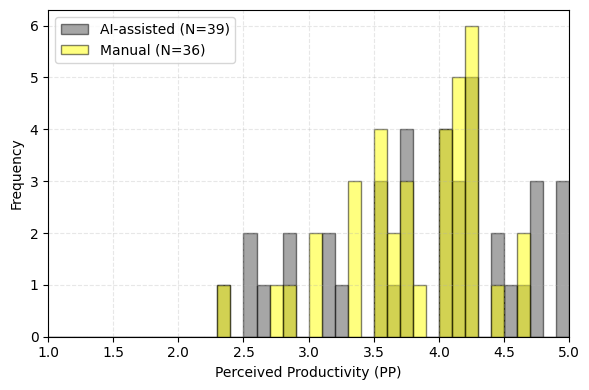

In [19]:
plt.figure(figsize=(6, 4))

# Drop NaNs and count
ai_pp = task1_ai_group['pp_mean'].dropna()
manual_pp = task1_manual_group['pp_mean'].dropna()

# Legend labels with sample sizes
ai_label = f"AI-assisted (N={len(ai_pp)})"
manual_label = f"Manual (N={len(manual_pp)})"

# Define fixed bins from 1 to 5 (Likert scale)
bins = np.linspace(1, 5, 41)  # 0.1-width bins for smoother plot

# Plot histograms
plt.hist(ai_pp, bins=bins, 
         color=colors['ai_dark_gray'], alpha=0.5, edgecolor='black', label=ai_label)
plt.hist(manual_pp, bins=bins, 
         color=colors['manual_work'], alpha=0.5, edgecolor='black', label=manual_label)

# Labels and style
plt.xlabel('Perceived Productivity (PP)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(1, 5)
plt.tight_layout()

plt.savefig("figures/task1_pp_distribution.png", dpi=300)
plt.show()


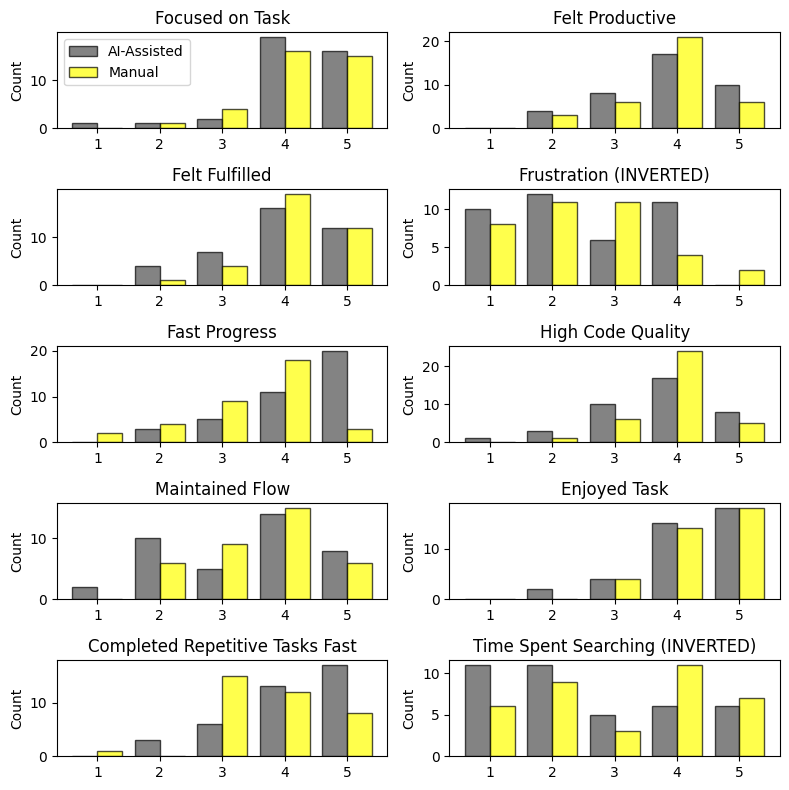

In [20]:
# Create a figure with subplots
plt.figure(figsize=(8, 8))

for i, column in enumerate(likert_columns, 1):
    ax = plt.subplot(5, 2, i)  # Arrange subplots in a 5x2 grid

    # Compute response counts for each Likert scale value (1–5)
    ai_counts = task1_ai_group[column].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    manual_counts = task1_manual_group[column].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

    # Combine into a DataFrame
    combined_counts = pd.DataFrame({'AI-Assisted': ai_counts, 'Manual': manual_counts})

    # Plot with legend only on first subplot
    plot = combined_counts.plot(kind='bar', ax=ax, alpha=0.7, width=0.8,
                                color=[colors['ai_dark_gray'], colors['manual_work']],
                                edgecolor='black', xlabel="")
    if i != 1:
        ax.get_legend().remove()

    plt.title(column_labels[column])
    plt.ylabel('Count')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig("figures/task1_likert_responses.png", dpi=300)
plt.show()


# Task 2

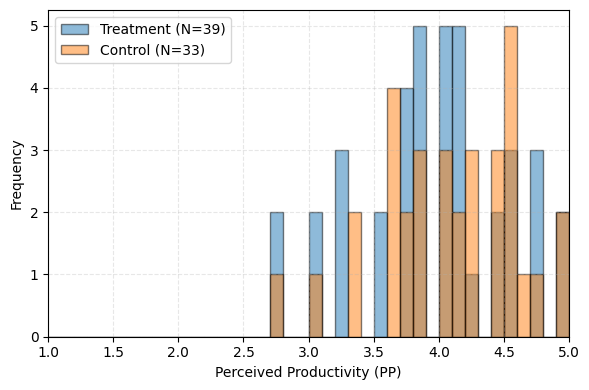

In [21]:
plt.figure(figsize=(6, 4))

# Drop NaNs and count
treatment_pp = task2_treatment['pp_mean'].dropna()
control_pp = task2_control['pp_mean'].dropna()

# Legend labels with sample sizes
treatment_label = f"Treatment (N={len(treatment_pp)})"
control_label = f"Control (N={len(control_pp)})"

# Define fixed bins from 1 to 5 (Likert scale)
bins = np.linspace(1, 5, 41)  # 0.1-width bins

# Plot histograms
plt.hist(treatment_pp, bins=bins, 
         color=colors['treatment_blue'], alpha=0.5, edgecolor='black', label=treatment_label)
plt.hist(control_pp, bins=bins, 
         color=colors['control_orange'], alpha=0.5, edgecolor='black', label=control_label)

# Labels and style
plt.xlabel('Perceived Productivity (PP)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(1, 5)
plt.tight_layout()

plt.savefig("figures/task2_pp_distribution.png", dpi=300)
plt.show()


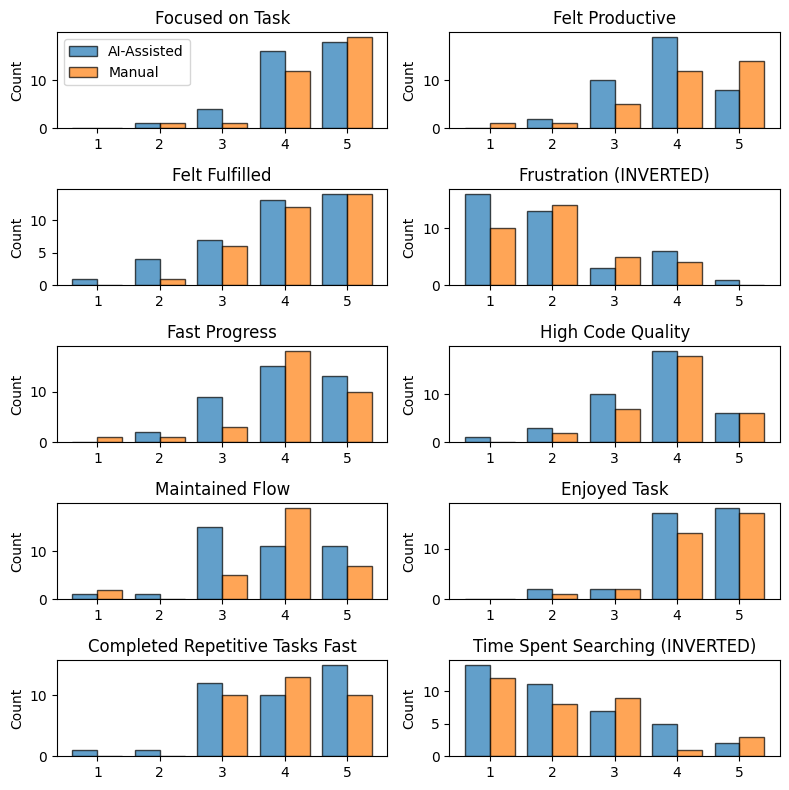

In [12]:
# Create a figure with subplots
plt.figure(figsize=(8, 8))

for i, column in enumerate(likert_columns, 1):
    ax = plt.subplot(5, 2, i)

    # Compute response counts for each Likert scale value (1–5)
    ai_counts = task2_treatment[column].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    manual_counts = task2_control[column].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

    # Combine into a DataFrame
    combined_counts = pd.DataFrame({'AI-Assisted': ai_counts, 'Manual': manual_counts})

    # Plot with single legend in the first subplot
    plot = combined_counts.plot(kind='bar', ax=ax, alpha=0.7, width=0.8,
                                color=[colors['treatment_blue'], colors['control_orange']],
                                edgecolor='black', xlabel="")
    if i != 1:
        ax.get_legend().remove()

    plt.title(column_labels[column])
    plt.ylabel('Count')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig("figures/task2_likert_responses.png", dpi=300)
plt.show()


In [23]:
# Extract clean_time values in seconds
treatment_pp = task2_treatment['pp_mean'].dropna()
control_pp = task2_control['pp_mean'].dropna()

# Shapiro–Wilk normality test
stat_treat, p_treat = shapiro(treatment_pp)
stat_control, p_control = shapiro(control_pp)

print("Shapiro–Wilk Test for Normality:")
print(f"  Treatment: W = {stat_treat:.4f}, p = {p_treat:.4e}")
print(f"  Control:   W = {stat_control:.4f}, p = {p_control:.4e}")

Shapiro–Wilk Test for Normality:
  Treatment: W = 0.9674, p = 3.1186e-01
  Control:   W = 0.9663, p = 3.8413e-01


We don't reject the null hypothesis for normality.

In [27]:
# Levene's test for equal variances
stat_levene, p_levene = levene(treatment_pp, control_pp)

print("Levene’s Test for Equality of Variances:")
print(f"  W = {stat_levene:.4f}, p = {p_levene:.4e}")

Levene’s Test for Equality of Variances:
  W = 0.0147, p = 9.0394e-01


We don't reject the null hypothesis for non-equal variance.

In [31]:
# Welch’s t-test
stat, p = ttest_ind(treatment_pp, control_pp, equal_var=True)

print("Welch’s t-test on Perceived Productivity (PP):")
print(f"  t-statistic = {stat:.4f}")
print(f"  p-value     = {p:.4e}")

Welch’s t-test on Perceived Productivity (PP):
  t-statistic = -0.8997
  p-value     = 3.7134e-01


We cannot reject the null hypothesis for difference.

In [32]:
# Function to compute Cohen's d
def cohens_d(group1, group2):
    """Compute Cohen's d for effect size between two groups."""
    group1 = group1.dropna()
    group2 = group2.dropna()
    
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2) /
                         (len(group1) + len(group2) - 2))
    
    return (mean1 - mean2) / pooled_std

# Compute Cohen's d for pp_mean
effect_size = cohens_d(task2_treatment['pp_mean'], task2_control['pp_mean'])

# Print and interpret
print(f"Cohen's d for Perceived Productivity (PP Mean): {effect_size:.4f}")

if abs(effect_size) < 0.2:
    interpretation = "Negligible"
elif abs(effect_size) < 0.5:
    interpretation = "Small"
elif abs(effect_size) < 0.8:
    interpretation = "Medium"
else:
    interpretation = "Large"

print(f"Effect Size Interpretation: {interpretation}")

Cohen's d for Perceived Productivity (PP Mean): -0.2128
Effect Size Interpretation: Small


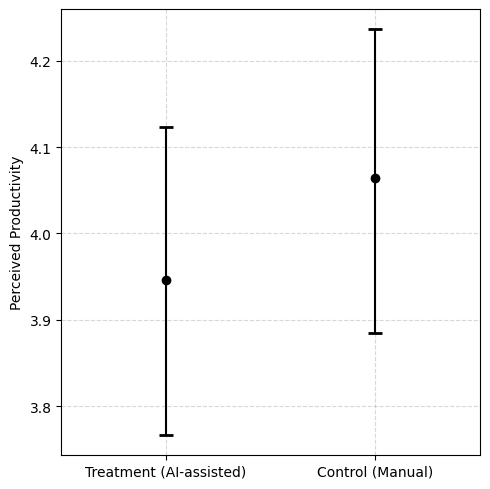

Bootstrap Confidence Intervals (95% CI) for Perceived Productivity:
Treatment (AI-assisted): 3.95  (95% CI: 3.77 - 4.12)
Control (Manual):       4.06  (95% CI: 3.88 - 4.24)


In [34]:
# Function to compute percentile bootstrap confidence interval for the mean
def bootstrap_ci_mean(data, n_bootstraps=1000000, ci=95):
    boot_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(data), lower, upper

# Compute Bootstrap CIs for PP Mean in Task 2
pp_treatment_mean, pp_treatment_lower, pp_treatment_upper = bootstrap_ci_mean(task2_treatment['pp_mean'].dropna())
pp_control_mean, pp_control_lower, pp_control_upper = bootstrap_ci_mean(task2_control['pp_mean'].dropna())

# Error bars
lower_bounds = [pp_treatment_mean - pp_treatment_lower, pp_control_mean - pp_control_lower]
upper_bounds = [pp_treatment_upper - pp_treatment_mean, pp_control_upper - pp_control_mean]
yerr_pp = [lower_bounds, upper_bounds]

# Plot
plt.figure(figsize=(5, 5))
x_pos = [0, 1]
means = [pp_treatment_mean, pp_control_mean]
plt.errorbar(x_pos, means, yerr=yerr_pp, fmt='o', capsize=5, capthick=2, color='black')

# Fix x-axis
plt.xticks(x_pos, ['Treatment (AI-assisted)', 'Control (Manual)'])
plt.xlim(-0.5, 1.5)
plt.ylabel('Perceived Productivity')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("figures/task2_bootstrap_ppmean_ci.png", dpi=300)
plt.show()

# Print numerical results
print("Bootstrap Confidence Intervals (95% CI) for Perceived Productivity:")
print(f"Treatment (AI-assisted): {pp_treatment_mean:.2f}  (95% CI: {pp_treatment_lower:.2f} - {pp_treatment_upper:.2f})")
print(f"Control (Manual):       {pp_control_mean:.2f}  (95% CI: {pp_control_lower:.2f} - {pp_control_upper:.2f})")